In [85]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from copy import copy

In [86]:
import skbeam
from skbeam.core.image import find_ring_center_acorr_1D
from skbeam.core.utils import bin_1D, radial_grid, bin_edges_to_centers
from skbeam.core.calibration import estimate_d_blind, refine_center
from skbeam.core.utils import img_to_relative_xyi
import numpy as np
from pims.api import TiffStack
import os.path
pixel_size = (.2, .2)

## Define some helpful functions

In [87]:
def estimate_d(img, name, wavelength, pixel_size, mask=None):
    # find the center
    res = find_ring_center_acorr_1D(img)
    res2 = refine_center(img, res, pixel_size, 25, 5, thresh=0.1, window_size=5)
    x,y,I = img_to_relative_xyi(img, res2[1], res2[0], pixel_size[1], pixel_size[0])
    # used to be bins, sums, counts
    d = np.sqrt(x**2+y**2)
    if mask is not None:
        mask = mask.flatten()
        ind = np.where(mask==1)[0]
        # number of bins is set to 3 times the maximum of d
        bins,sums,counts = bin_1D(d[ind],I[ind],nx=np.max(d)*3)
    else:
        bins,sums,counts = bin_1D(d,I,nx=np.max(d)*3)
    countMask = counts > 10
    bin_centers = bin_edges_to_centers(bins)[countMask]
    ring_averages = sums[countMask] / counts[countMask]    
    d_mean, d_std = estimate_d_blind(name,wavelength, bin_centers,
                                     ring_averages, 5, 7, thresh=0.03)
    return d_mean, d_std, res2

def show_rings_on_image(ax, image, ring_radius, center):
    vmin, vmax = np.percentile(image, [80, 100])
    my_cmap = copy(matplotlib.cm.get_cmap('gray'))
    my_cmap.set_bad('k')
    im = ax.imshow(image, cmap=my_cmap, interpolation='none', norm=LogNorm(), vmin=vmin, vmax=vmax)
    for r in ring_radius:
        c = Circle(center[::-1], r , facecolor='none', edgecolor='r', lw=2, linestyle='dashed')
        ax.add_patch(c)
    ax.axhline(center[0], color='r')
    ax.axvline(center[1], color='r')

    ax.set_ylim([center[0] - ring_radius[-1], center[0] + ring_radius[-1]])
    ax.set_xlim([center[1] - ring_radius[-1], center[1] + ring_radius[-1]])

## Setup data for Si standard sample

<IPython.core.display.Javascript object>


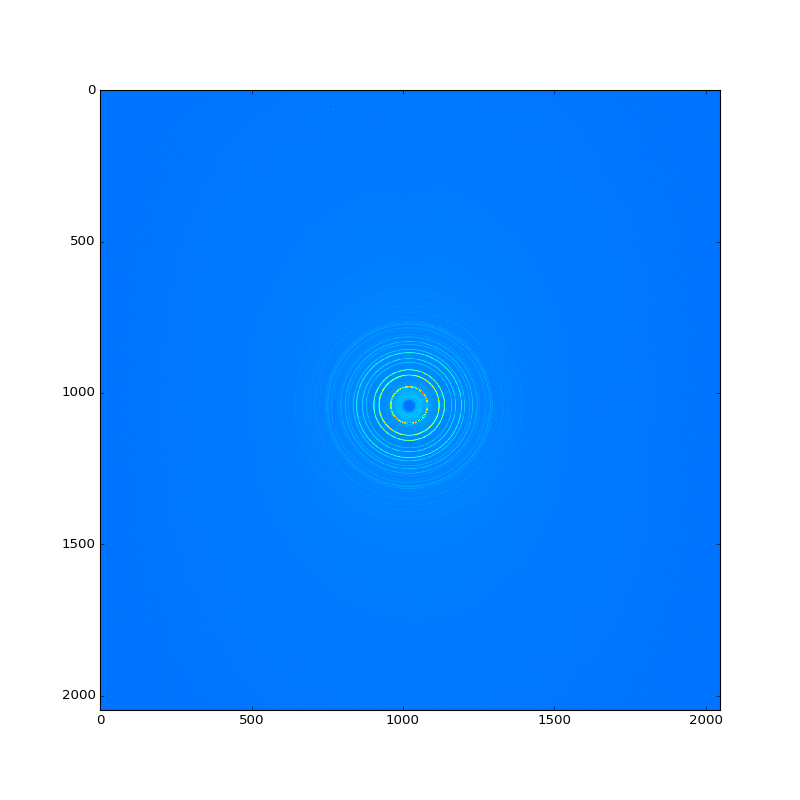

In [88]:
si_fname = 'Si_STD_d204-00002.tif'
si_name = 'Si'
si_wavelength = 0.1839
si_data = TiffStack(si_fname,dtype='int')
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(si_data[0],interpolation='none')

## Setup data for LaB6 calibration standard

<IPython.core.display.Javascript object>


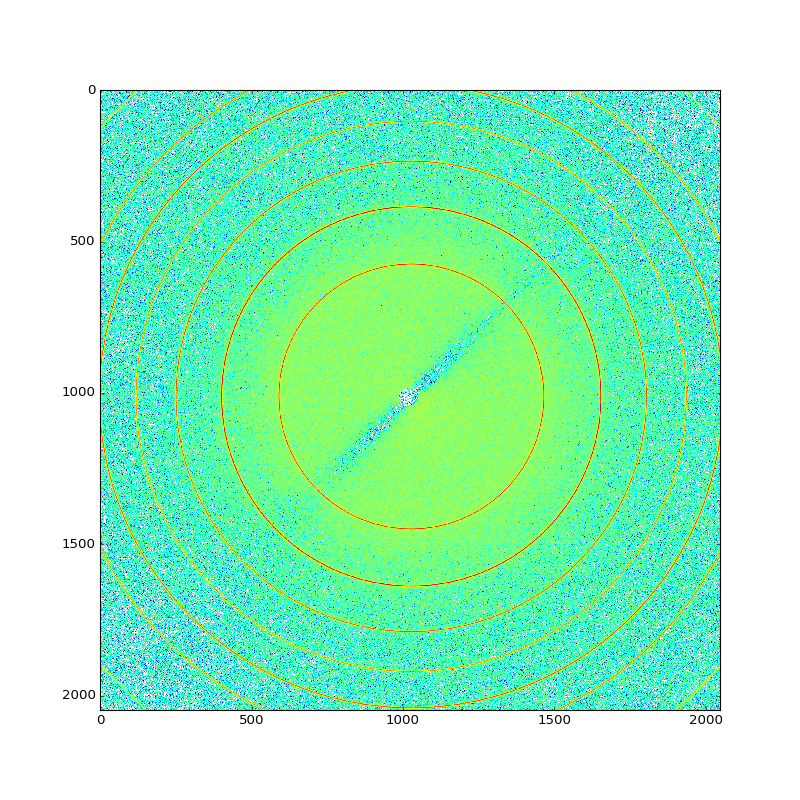

In [89]:
lab6_fname = 'LaB6_d500-0p72959-2Kx2K_pix200.tif'
lab6_name = 'LaB6'
lab6_wavelength = .72959
lab6_data = TiffStack(lab6_fname, dtype='int')
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.log(lab6_data[0]),interpolation='none')

## Calibrate Si data

In [90]:
calib_si = estimate_d(si_data[0], si_name, si_wavelength, pixel_size)
print("D: {} ± {}".format(calib_si[0], calib_si[1]))
print("center: {}".format(calib_si[2]))

D: 206.54687354536938 ± 0.44676404752969634
center: (1040.5375337561584, 1020.3334525778171)


<IPython.core.display.Javascript object>


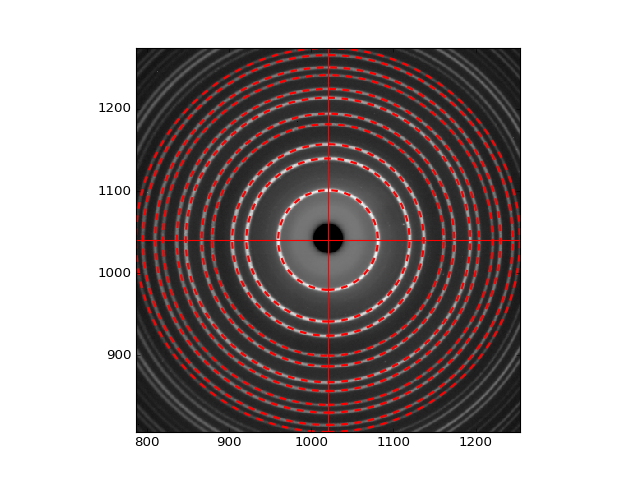

In [91]:
cal_si = skbeam.core.calibration.calibration_standards['Si']
si_rings = calib_si[0] * np.tan(cal_si.convert_2theta(si_wavelength)) / .2
fig, ax = plt.subplots()
show_rings_on_image(ax, si_data[0], si_rings, calib_si[2])

## Calibrate using Lab 6 data

In [92]:
calib_lab6 = estimate_d(lab6_data[0], lab6_name, lab6_wavelength, pixel_size)
print("D: {} ± {}".format(calib_lab6[0], calib_lab6[1]))
print("center: {}".format(calib_lab6[2]))

D: 493.24928496090615 ± 0.44625343620719043
center: (1011.735038759629, 1027.5116910034903)


In [101]:
cal_lab6 = nsls2.calibration.calibration_standards['LaB6']
lab6_rings = calib_lab6[0] * np.tan(cal_lab6.convert_2theta(lab6_wavelength)) / .2
fig, ax = plt.subplots()
show_rings_on_image(ax, lab6_data[0], lab6_rings, calib_lab6[2])
ax.set_xlim([0, lab6_data.frame_shape[0]])
ax.set_ylim([0, lab6_data.frame_shape[1]])
plt.show()

NameError: name 'nsls2' is not defined